# Prepare radiosondes

This script is for documentation only. Running it requires downloading radiosonde observations (nsainterpolatedsondeC1) from https://wwww.arm.gov/data

Because this is only a toy retrieval, we made a couple of important simplifications:
* Instead of using the radiosondes directly, the ARM interpolated radiosonde product is used for convenience at standard observations times. 
* The filtering of outliers is very crude
* Only every 5th available height level is used. 

When designing an operational retrieval, these shortcomings should be addressed.

In [1]:
import xarray as xr
import pandas as pn
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pamtra2
import supporting_routines
%matplotlib inline

Open data



In [2]:
interpolatedsonde = xr.open_mfdataset('/psd3data/oliktok/RawData/ARM/nsa/sonde/nsainterpolatedsondeC1/nsainterpolatedsondeC1.c1.*.nc')



/home/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Select data every 6 hours

In [3]:
interpolatedsondeRS = interpolatedsonde.resample(time='6H').nearest(
    tolerance='1H')

Apply quality flags

In [4]:
variables = [
    'temp',
    'rh',
    'bar_pres',
    'dp',
]

for var in variables:
    interpolatedsondeRS[var] = interpolatedsondeRS[var].where(
        interpolatedsondeRS['qc_%s' % var] == 0)
interpolatedsondeRS = interpolatedsondeRS[variables]

In [5]:
for k in list(interpolatedsondeRS.attrs.keys()):
    del interpolatedsondeRS.attrs[k]

remove invalid data

In [6]:
interpolatedsondeRS = interpolatedsondeRS.dropna('time', how='all')
interpolatedsondeRS = interpolatedsondeRS.dropna('height', how='all')

estimate and plot potential temperature

In [7]:
tpot = pamtra2.libs.meteo_si.temperature.T_pot(
    interpolatedsondeRS['temp']+ 273.15, interpolatedsondeRS['bar_pres'] * 1000)


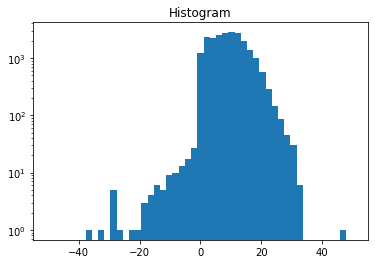

In [8]:
lts = tpot - tpot[:, 0]
level_925 = np.nanargmin(np.abs(interpolatedsondeRS.bar_pres.mean('time').values - 92.5))
lts[:, level_925].plot.hist(bins=np.linspace(-50, 50))
plt.yscale('log')

remove outliers and plot again



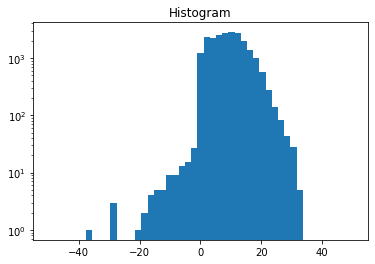

In [9]:
II = np.where(~((interpolatedsondeRS['temp'].diff('height') > 11).any('height')))[0]

lts.isel(time=II)[:, level_925].plot.hist(bins=np.linspace(-50, 50).tolist())
plt.yscale('log')

limit to every 5th height

In [10]:
hh = slice(0, 300, 5)
interpolatedsondeRS_5 = interpolatedsondeRS.isel(height=hh, time=II)

In [11]:
interpolatedsondeRS_5.load()

<xarray.Dataset>
Dimensions:   (height: 60, time: 24095)
Coordinates:
  * time      (time) datetime64[ns] 2002-04-29 ... 2020-02-04T18:00:00
  * height    (height) float32 0.008 0.107999995 ... 20.008007 22.508007
Data variables:
    temp      (time, height) float32 -11.4468975 -10.507055 ... -45.524162
    rh        (time, height) float32 74.25851 77.52467 ... 0.5102128 0.5082667
    bar_pres  (time, height) float32 101.90272 100.83725 ... 5.1028395 3.5113027
    dp        (time, height) float32 -14.990514 -13.192951 ... -84.815704

Convert to SI units

In [13]:
interpolatedsondeRS_5['height'] = interpolatedsondeRS_5.height * 1000
interpolatedsondeRS_5['temp'] = interpolatedsondeRS_5.temp + 273.15
interpolatedsondeRS_5['bar_pres'] = interpolatedsondeRS_5.bar_pres * 1000
interpolatedsondeRS_5['rh'] = interpolatedsondeRS_5.rh / 100
interpolatedsondeRS_5['q'] = pamtra2.libs.meteo_si.humidity.rh2q(interpolatedsondeRS_5.rh, interpolatedsondeRS_5.temp,
                                                 interpolatedsondeRS_5.bar_pres) * 1000

In [14]:
interpolatedsondeRS_5 = interpolatedsondeRS_5[['temp','q','bar_pres']]

Store data using best possible compression

In [15]:
for var in interpolatedsondeRS_5.variables:
    interpolatedsondeRS_5[var].encoding = {}
    interpolatedsondeRS_5[var].encoding['zlib']=True  
    interpolatedsondeRS_5[var].encoding['complevel'] = 9 
    interpolatedsondeRS_5[var].encoding['_FillValue'] = -9999 


interpolatedsondeRS_5['temp'].encoding['dtype'] = 'uint16' 
interpolatedsondeRS_5['temp'].encoding['scale_factor'] = 0.01 
interpolatedsondeRS_5['bar_pres'].encoding['dtype'] = 'uint16' 
interpolatedsondeRS_5['bar_pres'].encoding['scale_factor'] = 10 
interpolatedsondeRS_5['time'].encoding['dtype']='uint32'   

interpolatedsondeRS_5.to_netcdf('../data/radiosonde_climatology_nsa_2002-2020.nc')